Ganti GPU:
- klik menu Runtime
- Ubah jenis Runtime
- Akselerator pilih GPU

Urutan Pengerjaan:
1. Download dataset, boleh gunain API dan terkoneksi ke google colab
2. Cek lokasi Path dari gambar
3. Kita load data: Menggunakan dataframe, **directory**, tfrecord
3. EDA: cek shape, imagenya ukurannya seperti apa?, pola gambarnya seperti apa?, ada noise kah? dll
4. Augementasi Data: ImageDataGenerator, **tf.keras.layers**
5. bisa coba terapkan `prefetch`
6. Pembuatan model 
7. compile
8. fit
9. evaluasi
11. inference



# Data Loading

In [1]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

labeled-chest-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# !unzip -q /content/labeled-chest-xray-images.zip -d dataset
!unzip -q labeled-chest-xray-images.zip -d ./content

In [56]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, Input

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [14]:
os.listdir('./content/chest_xray')

['test', 'train']

In [13]:
main_path= './content/chest_xray'

In [15]:
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')

In [16]:
print('train set: \n' + '='*50)
num_pneumonia= len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal= len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f'jumlah pneumonia= {num_pneumonia}')
print(f'jumlah normal= {num_normal}')

train set: 
jumlah pneumonia= 3883
jumlah normal= 1349


In [17]:
print('test set: \n' + '='*50)
num_pneumonia= len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
num_normal= len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f'jumlah pneumonia= {num_pneumonia}')
print(f'jumlah normal= {num_normal}')

test set: 
jumlah pneumonia= 390
jumlah normal= 234


In [18]:
train_normal = glob.glob(train_dir+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_dir+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_dir+"/PNEUMONIA/*.jpeg")

# EDA

/content/images/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg

/content/images/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg

In [19]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        ##ambil nama dari file \ ke -1
        # images.append(image.split('\')[-1]) 
        # label.append(image.split('\')[-2])
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_normal + train_pneumonia)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_normal + test_pneumonia)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [20]:
print(train_df.shape)
train_df.head()

(5232, 2)


,images,label
0,./content/chest_xray/train/PNEUMONIA/BACTERIA-...,PNEUMONIA
1,./content/chest_xray/train/PNEUMONIA/BACTERIA-...,PNEUMONIA
2,./content/chest_xray/train/NORMAL/NORMAL-64331...,NORMAL
3,./content/chest_xray/train/NORMAL/NORMAL-11969...,NORMAL
4,./content/chest_xray/train/NORMAL/NORMAL-72740...,NORMAL


In [21]:
print(test_df.shape)
test_df.head()

(624, 2)


,images,label
0,./content/chest_xray/test/PNEUMONIA/BACTERIA-5...,PNEUMONIA
1,./content/chest_xray/test/NORMAL/NORMAL-656925...,NORMAL
2,./content/chest_xray/test/NORMAL/NORMAL-431557...,NORMAL
3,./content/chest_xray/test/NORMAL/NORMAL-345919...,NORMAL
4,./content/chest_xray/test/PNEUMONIA/VIRUS-9783...,PNEUMONIA


In [22]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1, stratify = train_df['label'])
print(train_df.shape)
print(val_df.shape)

(4185, 2)
(1047, 2)


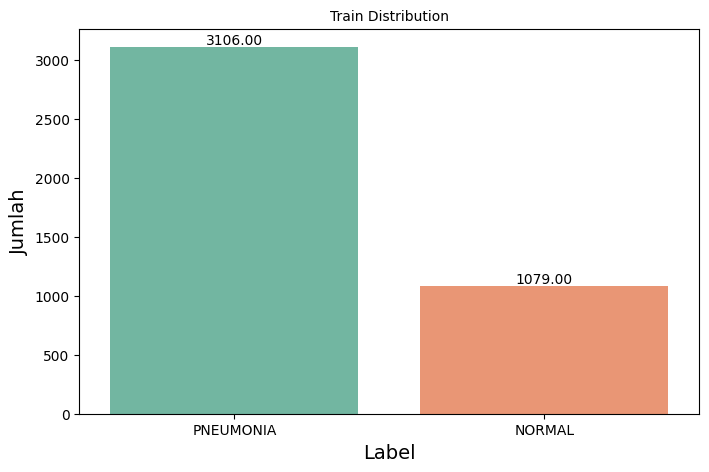

In [23]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')

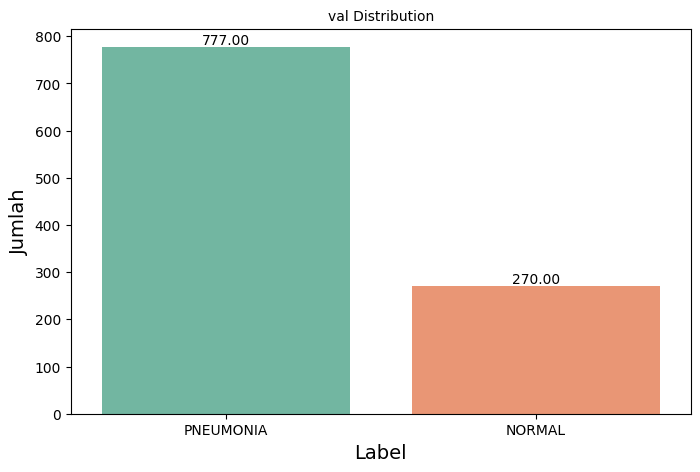

In [24]:
visualize_data(val_df, 'val')

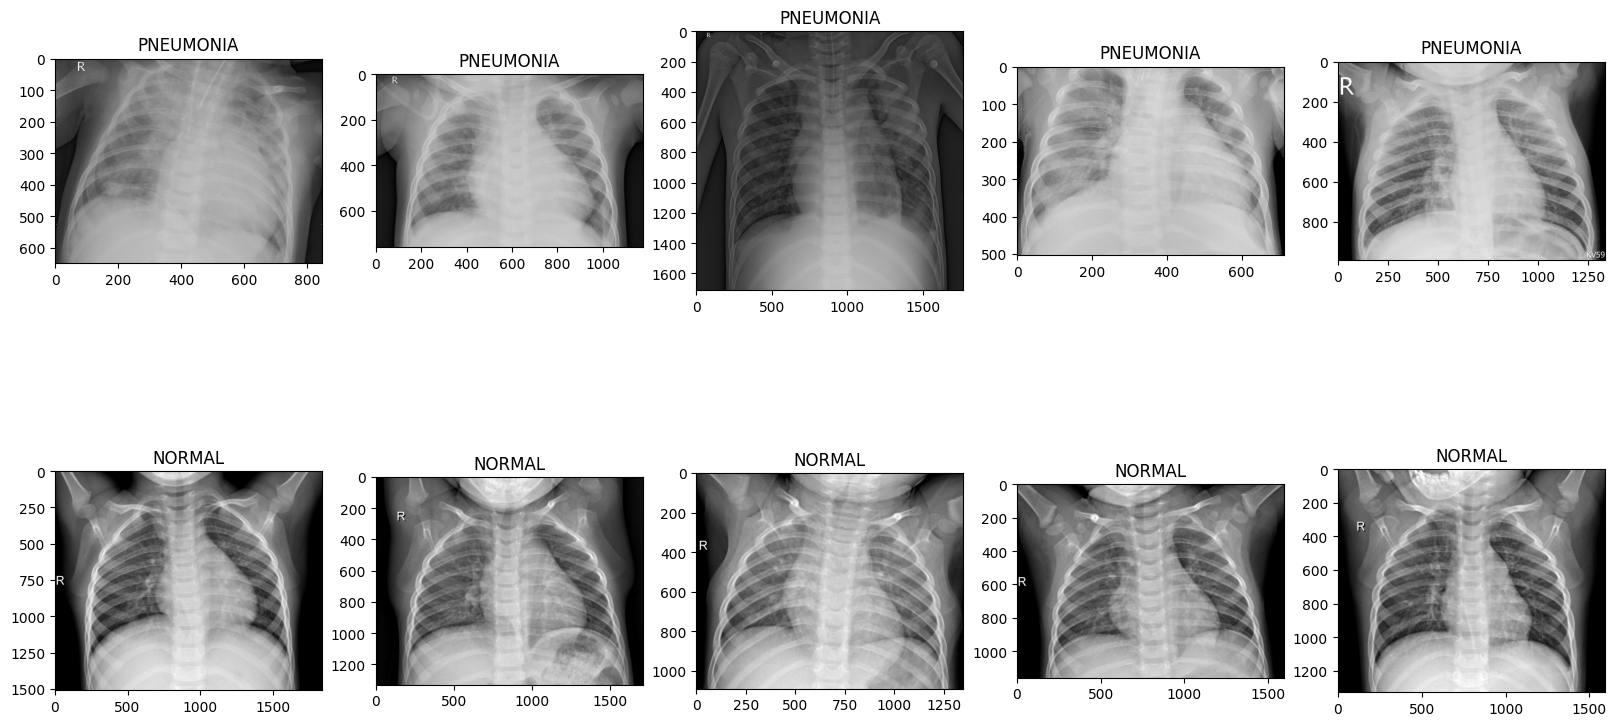

In [25]:
# Get few samples for both the classes
pneumonia_samples = (train_df[train_df['label']=="PNEUMONIA"]['images'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']=='NORMAL']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(pneumonia_samples + normal_samples)

# Augmentasi Data

In [26]:
img_height= 220
img_width= 220
SEED = 1
BATCH =64

In [27]:
# create image generator
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# train = image_generator.flow_from_directory(directory='/content/images/chest_xray/train', 
#                                             batch_size=8, 
#                                             shuffle=True, 
#                                             class_mode='binary',
#                                             target_size=(320, 320))

# validation = image_generator.flow_from_directory(directory='/content/images/chest_xray/train', 
#                                                 batch_size=1, 
#                                                 shuffle=False, 
#                                                 class_mode='binary',
#                                                 target_size=(320, 320))

# test = image_generator.flow_from_directory(directory='/content/images/chest_xray/test', 
#                                             batch_size=1, 
#                                             shuffle=False, 
#                                             class_mode='binary',
#                                             target_size=(320, 320))

In [28]:
# dari dataframe bukan directory
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width), #ini buat nentuin target biar sama sizenya
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

df_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [29]:
ds_train.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Coba pipeline dengan tf.data(image_dataset_from_directory) dan prefetch:
```
  AUTOTUNE = tf.data.AUTOTUNE

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
```
Referensi: 
- [Tensorflow Image Classification + Augmentation](https://www.tensorflow.org/tutorials/images/classification)
- [Tensorflow Augmentasi](https://www.tensorflow.org/tutorials/images/data_augmentation)

# Modeling

In [31]:
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
    # ReduceLRonPlateau
]

In [40]:
inputs= [img_height,img_width,3]

# arsitektur model
model_jason= Sequential()

# layer conv 1, bisa coba atur kernel_initializer dan activation
model_jason.add(
 Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=inputs)
)
model_jason.add(MaxPooling2D(pool_size=2, strides=2))

# Layer Conv 2
model_jason.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model_jason.add(MaxPooling2D(pool_size=2, strides=2))

# Layer Conv 3
model_jason.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model_jason.add(MaxPooling2D(pool_size=2, strides=2))

model_jason.add(Flatten())
model_jason.add(Dense(units=128, activation='relu'))
model_jason.add(Dense(units=1, activation='sigmoid'))

In [41]:
model_jason.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 109, 109, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 64)      

In [42]:
model_jason.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

catatan : epoch jangan coba 7 aja, bisa coba 20 atau 50

bisa tambahkan di history:
```
steps_per_epoch=(len(df_train)/BATCH),
validation_steps=(len(ds_val)/BATCH))
```

In [43]:
history= model_jason.fit(ds_train, batch_size= BATCH, 
                           epochs= 20, validation_data= ds_val,
                           callbacks= callbacks1)

Epoch 1/20


2022-12-05 13:59:37.183893: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-05 13:59:37.744481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.7527

2022-12-05 14:00:29.127781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 59s 858ms/step - loss: 0.5281 - accuracy: 0.7527 - val_loss: 0.2949 - val_accuracy: 0.8768
Epoch 2/20
66/66 [==============================] - 59s 900ms/step - loss: 0.3232 - accuracy: 0.8526 - val_loss: 0.3870 - val_accuracy: 0.8052
Epoch 3/20
66/66 [==============================] - 60s 906ms/step - loss: 0.2957 - accuracy: 0.8669 - val_loss: 0.2807 - val_accuracy: 0.8844
Epoch 4/20
66/66 [==============================] - 61s 926ms/step - loss: 0.2647 - accuracy: 0.8915 - val_loss: 0.2072 - val_accuracy: 0.9198
Epoch 5/20
66/66 [==============================] - 60s 909ms/step - loss: 0.2613 - accuracy: 0.8910 - val_loss: 0.4069 - val_accuracy: 0.8195
Epoch 6/20
66/66 [==============================] - 59s 900ms/step - loss: 0.2506 - accuracy: 0.8949 - val_loss: 0.3537 - val_accuracy: 0.8443
Epoch 7/20
66/66 [==============================] - 58s 876ms/step - loss: 0.2372 - accuracy: 0.9004 - val_loss: 0.2017 - val_accuracy: 0.9093
Epoch 8/20

# Evaluasi

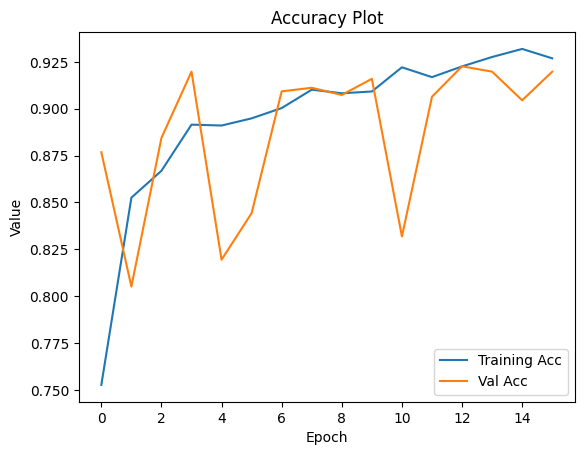

In [44]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

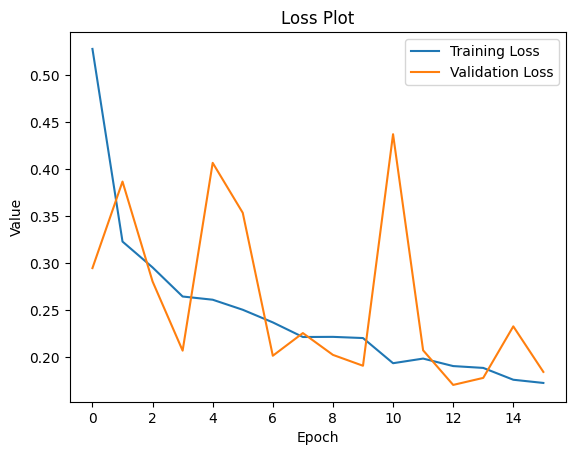

In [45]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [46]:
test_results = model_jason.evaluate(df_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.3455
Test Accuracy : 0.8686


Bisa coba cek classification_report, dll

# Transfer learning

In [47]:
# transfer learning

# callback2
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience=4),
    ModelCheckpoint('model_best2.hdf5', monitor='val_loss', save_best_only=True)
]

pretrained_model = tf.keras.applications.Xception(
    include_top=False, input_shape=inputs, pooling='avg'
)
pretrained_model.trainable = False

83683744/83683744 [==============================] - 9s 0us/step


penjelasan tentang [freezing](https://analyticsindiamag.com/what-does-freezing-a-layer-mean-and-how-does-it-help-in-fine-tuning-neural-networks/)

In [50]:
# Create the model
model_ocha = Sequential()
model_ocha.add(pretrained_model)
model_ocha.add(Flatten())
model_ocha.add(Dense(128, activation='relu'))
model_ocha.add(Dense(128, activation='relu'))
model_ocha.add(Dense(1, activation='sigmoid'))

In [51]:
model_ocha.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 128)               262272    
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 21,140,393
Trainable params: 278,913
Non-trainable params: 20,861,480
_________________________________________________________________


In [54]:
model_ocha.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [55]:
history2 = model_ocha.fit(ds_train, batch_size= BATCH, 
                           epochs= 10, validation_data= ds_val,
                           callbacks= callbacks2)        

Epoch 1/10


2022-12-05 14:25:27.228540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.8853

2022-12-05 14:26:51.271598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 105s 2s/step - loss: 0.2485 - accuracy: 0.8853 - val_loss: 0.2127 - val_accuracy: 0.9093
Epoch 2/10
66/66 [==============================] - 95s 1s/step - loss: 0.1614 - accuracy: 0.9376 - val_loss: 0.1773 - val_accuracy: 0.9217
Epoch 3/10
66/66 [==============================] - 94s 1s/step - loss: 0.1431 - accuracy: 0.9453 - val_loss: 0.1948 - val_accuracy: 0.9198
Epoch 4/10
66/66 [==============================] - 95s 1s/step - loss: 0.1423 - accuracy: 0.9470 - val_loss: 0.1370 - val_accuracy: 0.9522
Epoch 5/10
66/66 [==============================] - 99s 1s/step - loss: 0.1427 - accuracy: 0.9438 - val_loss: 0.2076 - val_accuracy: 0.9093
Epoch 6/10
66/66 [==============================] - 98s 1s/step - loss: 0.1219 - accuracy: 0.9503 - val_loss: 0.1826 - val_accuracy: 0.9293
Epoch 7/10
66/66 [==============================] - 98s 1s/step - loss: 0.1234 - accuracy: 0.9501 - val_loss: 0.1241 - val_accuracy: 0.9580
Epoch 8/10
66/66 [============

# Functional API

In [59]:
input_shape_img = Input(shape=inputs)
y = Conv2D(filters=32, kernel_size=3, activation='selu')(input_shape_img)
y = MaxPooling2D()(y)
y = Conv2D(filters=32, kernel_size=3, activation='selu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=64, kernel_size=3, activation='selu')(y)

y = Flatten()(y)
y = Dropout(0.2)(y)
outputs = Dense(1,activation='sigmoid')(y)

model = Model(inputs=input_shape_img, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 109, 109, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 107, 107, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 51, 51, 64)        1849

# Testing

Referensi: 
- [inference](https://colab.research.google.com/drive/1TuUlbAs6x3NZyAJjbJdZVQKsXXHVWAWz?usp=sharing#scrollTo=HTmIO-PHBO3J)

In [69]:
model_ocha.trainable = False

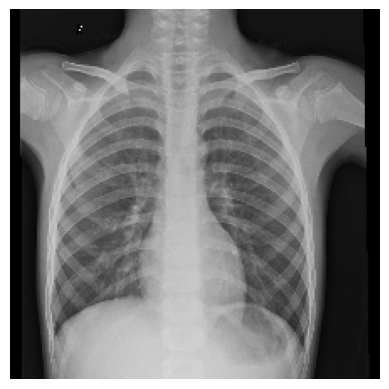

1/1 [==============================] - 0s 105ms/step
[[1.]]
pneumonia


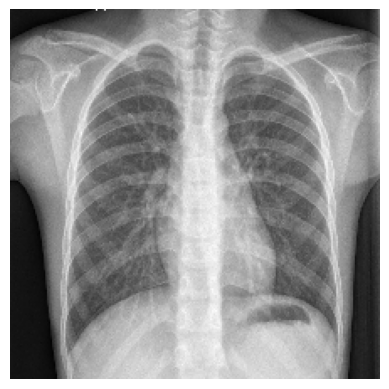

1/1 [==============================] - 0s 43ms/step
[[1.]]
pneumonia


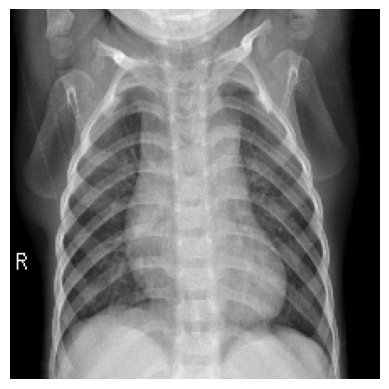

1/1 [==============================] - 0s 33ms/step
[[0.92175794]]
normal


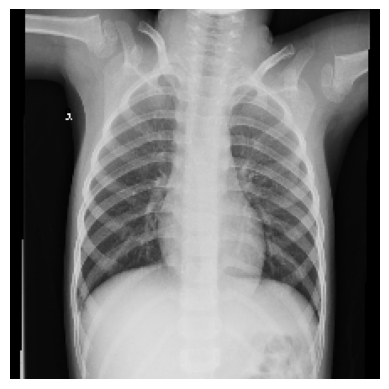

1/1 [==============================] - 0s 32ms/step
[[1.]]
pneumonia


In [82]:
import numpy as np
# from google.colab import files
from keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys():
for fn in test_normal[:4]:
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = tf.keras.utils.load_img(path, target_size=(img_height,img_width)) #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = tf.keras.utils.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model_ocha.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] == 1:
    print('pneumonia')
  else:
    print('normal')